In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
from cedalion.sigproc.artifact import id_motion, id_motion_refine
from cedalion.sigproc.motion_correct import motion_correct_PCA, motion_correct_PCA_recurse
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
from functools import reduce
import numpy as np

from cedalion import Quantity, units

Text(0, 0.5, 'Signal intensity / a.u.')

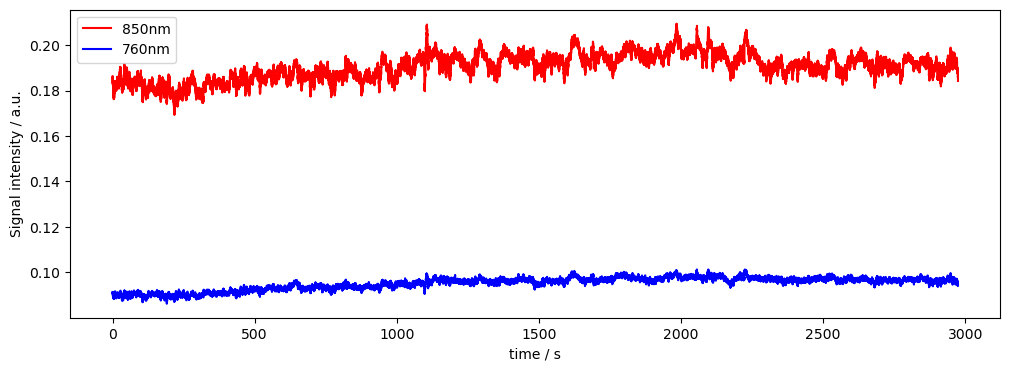

In [2]:
# get example finger tapping dataset
snirf_element = datasets.get_fingertapping()
amp = snirf_element[0].data[0]
geo = snirf_element[0].geo3d
od = cedalion.nirs.int2od(amp)

data = xr.Dataset(
    data_vars = {
        "amp" : amp,
        "od"  : od,
        "geo3d": geo
    })


# Plot some data for visual validation
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.amp.time, data.amp.sel(channel="S1D1", wavelength="850"), "r-", label="850nm")
ax.plot( data.amp.time, data.amp.sel(channel="S1D1", wavelength="760"), "b-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

# Detect motion and perform PCA filtering 

The motion_correct_PCA_recurse algortithm first detects motion in the the OD data. It then iteratively calls motion_correct_PCA which performs PCA filtering on all time points labelled as motion. 


In [3]:
# typical motion id parameters
t_motion = 0.5
t_mask = 1
stdev_thresh = 20
amp_thresh = 5

# motion identification 
tIncCh = id_motion(fNIRSdata=data.od, t_motion=t_motion, t_mask=t_mask, 
                   stdev_thresh=stdev_thresh, amp_thresh=amp_thresh) 
tInc = id_motion_refine(tIncCh, 'all')[0]
tInc.values = np.hstack([False, tInc.values[:-1]]) # manual shift to account for indexing differences

# call motion_correct_PCA
nSV=0.97 # discard n components up to 97% of variance 
od_cleaned, svs, nSV = motion_correct_PCA(fNIRSdata=data.od, tInc=tInc, nSV=nSV)


Text(0, 0.5, 'Optical density / a.u.')

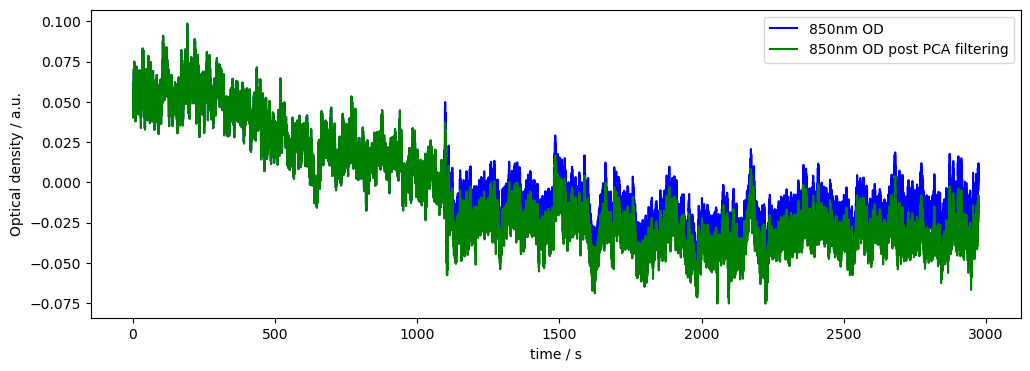

In [4]:
# plot difference between uncorrected OD and after PCA filter correction
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.od.time, data.od.sel(channel="S1D1", wavelength="760"), "b-", label="850nm OD")
ax.plot( od_cleaned.time, od_cleaned.sel(channel="S1D1", wavelength="760"), "g-", label="850nm OD post PCA filtering")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Optical density / a.u.")

# Iterative PCA filtering 

Above, the PCA filtering was performed once. motion_correct_PCA_recurse iteratively calls the motion detection and motion_correct_PCA until either it reaches the maximum number of iterations specified or until there is no longer any motion detected. 

In [22]:
maxIter = 5

od_cleaned_fully, svs, nSV, tInc = motion_correct_PCA_recurse(fNIRSdata=data.od, t_motion=t_motion, t_mask=t_mask, 
                   stdev_thresh=stdev_thresh, amp_thresh=amp_thresh, nSV=nSV, maxIter=maxIter)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

NameError: name 'od_cleaned_fully' is not defined

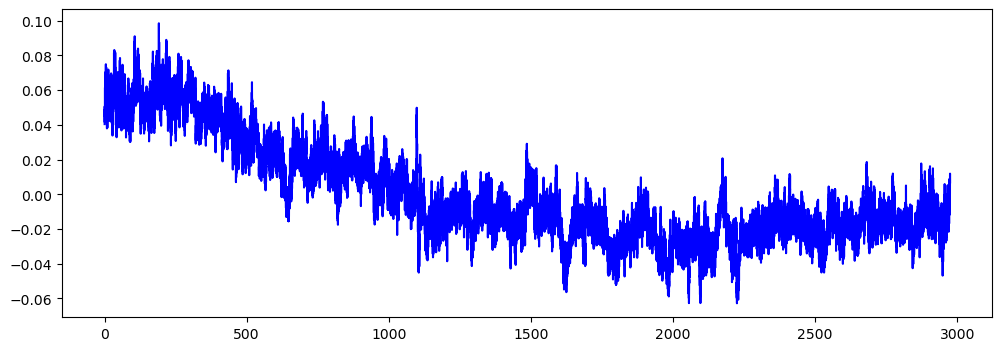

In [21]:
# plot difference between uncorrected OD and after iterative PCA filter correction
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.od.time, data.od.sel(channel="S1D1", wavelength="760"), "b-", label="850nm OD")
ax.plot( od_cleaned_fully.time, od_cleaned_fully.sel(channel="S1D1", wavelength="760"), "g-", label="850nm OD post PCA filtering")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Optical density / a.u.")